# IAA Laboratori 6 - Classification II . Resampling strategies

# Index

* Imbalanced datasets
* The metric trap
* Confusion matrix
* Resampling
* Random under-sampling
* Random over-sampling
* Python imbalanced-learn module
* Random under-sampling and over-sampling with imbalanced-learn
* Shrinking (under-sampling the majority class)
* Under-sampling: Tomek links
* Under-sampling: Cluster Centroids
* Over-sampling: SMOTE
* Recommended reading

In [19]:
%pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [20]:
# Loading libraries

# Basic libraries 
import pandas as pd
import numpy as np

# Metric for evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

In [21]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

# Imbalanced datasets

In this kernel we will know some techniques to handle highly unbalanced datasets, with a focus on resampling. The Porto Seguro's Safe Driver Prediction competition, used in this kernel, is a classic problem of unbalanced classes, since insurance claims can be considered unusual cases when considering all clients. Other classic examples of unbalanced classes are the detection of financial fraud and attacks on computer networks.

Let's see how unbalanced the dataset is:

Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


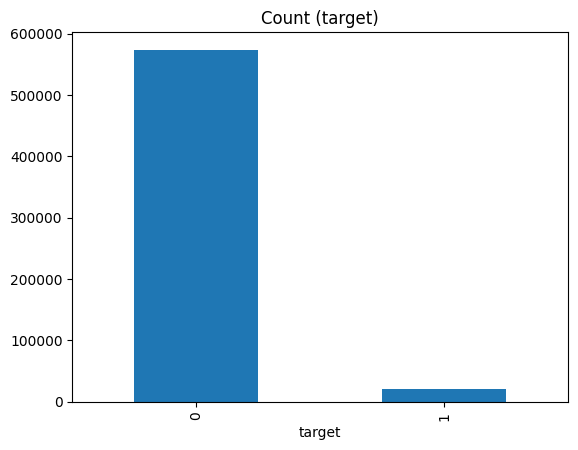

In [22]:
df_train = pd.read_csv('../../data/porto-seguro-safe-driver-prediction/train.csv')

target_count = df_train['target'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [23]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


## The metric trap

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like <code>accuracy_score</code> can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Let's do this experiment, using simple cross-validation and no feature engineering:

<div class="alert alert-success">
PLAYTIME: Why accuracy is not a good performance metric under data imbalance?
</div>

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LogisticRegression(C=1.0, random_state=1, solver='lbfgs', multi_class='ovr')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

LogisticRegression(multi_class='ovr', random_state=1)

Accuracy: 96.36%


In [25]:
print(classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    119043
           1       0.00      0.00      0.00         0

    accuracy                           0.96    119043
   macro avg       0.50      0.48      0.49    119043
weighted avg       1.00      0.96      0.98    119043



Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [26]:
model = LogisticRegression(C=1.0, random_state=1, solver='lbfgs', multi_class='ovr')
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

LogisticRegression(multi_class='ovr', random_state=1)

Accuracy: 96.36%


In [27]:
print(classification_report(model.predict(X_test[['ps_calc_01']]), y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    119043
           1       0.00      0.00      0.00         0

    accuracy                           0.96    119043
   macro avg       0.50      0.48      0.49    119043
weighted avg       1.00      0.96      0.98    119043



As we can see, the high accuracy rate was just an illusion. In this way, the choice of the metric used in unbalanced datasets is extremely important. In this competition, the evaluation metric is the Normalized Gini Coefficient, a more robust metric for imbalanced datasets, that ranges from approximately 0 for random guessing, to approximately 0.5 for a perfect score.

<h2 id="t3" style="margin-bottom: 18px">Confusion matrix</h2>

An interesting way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that all class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Confusion matrix:
 [[114709      0]
 [  4334      0]]


[Text(-1.0, 1, ''),
 Text(0.0, 1, 'Class 0'),
 Text(1.0, 1, 'Class 1'),
 Text(2.0, 1, '')]

[Text(0, -1.0, ''),
 Text(0, 0.0, 'Class 0'),
 Text(0, 1.0, 'Class 1'),
 Text(0, 2.0, '')]

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Expected')

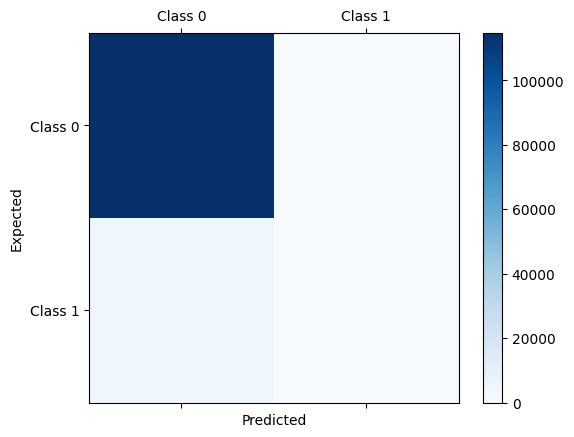

In [28]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

<div class="alert alert-success">
PLAYTIME: Can you explain it by looking at the confussion matrix and performance report?
</div>

# Resampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

Let's implement a basic example, which uses the <code>DataFrame.sample</code> method to get random samples each class:

In [29]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

## Random under-sampling


Random under-sampling:
target
0    21694
1    21694
Name: count, dtype: int64


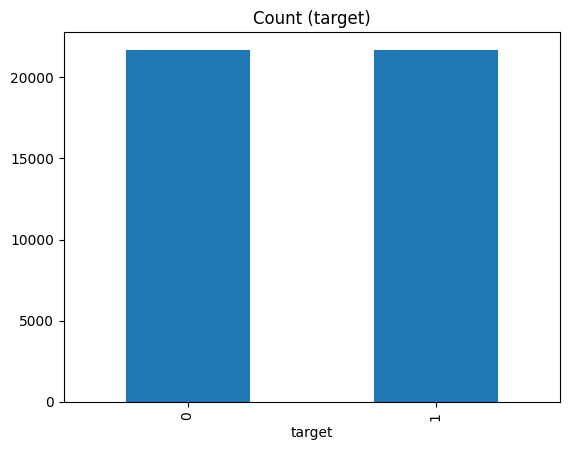

In [30]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

<h2 id="t6">Random over-sampling</h2>

Random over-sampling:
target
0    573518
1    573518
Name: count, dtype: int64


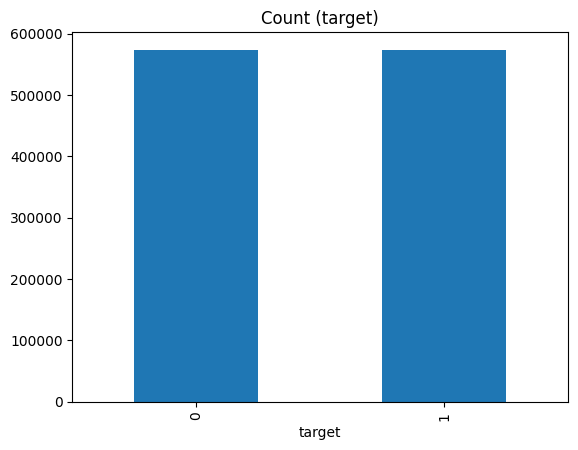

In [31]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [32]:
labels = df_test_over.columns[2:]

X = df_test_over[labels]
y = df_test_over['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LogisticRegression(C=1.0, random_state=1, solver='lbfgs', multi_class='ovr')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


LogisticRegression(multi_class='ovr', random_state=1)

Accuracy: 58.84%


Confusion matrix:
 [[72090 42750]
 [51666 62902]]


[Text(-1.0, 1, ''),
 Text(0.0, 1, 'Class 0'),
 Text(1.0, 1, 'Class 1'),
 Text(2.0, 1, '')]

[Text(0, -1.0, ''),
 Text(0, 0.0, 'Class 0'),
 Text(0, 1.0, 'Class 1'),
 Text(0, 2.0, '')]

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Expected')

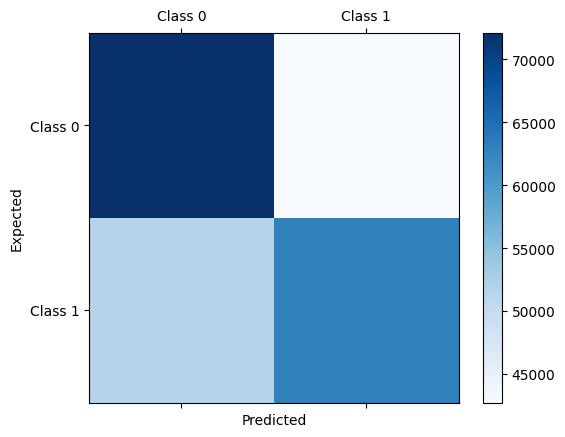

              precision    recall  f1-score   support

           0       0.63      0.58      0.60    123756
           1       0.55      0.60      0.57    105652

    accuracy                           0.59    229408
   macro avg       0.59      0.59      0.59    229408
weighted avg       0.59      0.59      0.59    229408



In [33]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

print(classification_report(model.predict(X_test), y_test))

In [34]:
labels = df_test_under.columns[2:]

X = df_test_under[labels]
y = df_test_under['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LogisticRegression(C=1.0, random_state=1, solver='lbfgs', multi_class='ovr')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

LogisticRegression(multi_class='ovr', random_state=1)

Accuracy: 58.83%


<div class="alert alert-success">
PLAYTIME: What did happen now to the confussion among classes?
</div>

# Problem definition: The ADULT dataset

ADULT dataset Description

Author: Ronny Kohavi and Barry Becker

Source: https://www.openml.org/search?type=data&sort=runs&id=1590&status=active

Please cite: Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996

Prediction task is to determine whether a person makes over 50K a year. Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

This is the original version from the UCI repository, with training and test sets merged.
Variable description

Variables are all self-explanatory except fnlwgt. This is a proxy for the demographic background of the people: "People with similar demographic characteristics should have similar weights". This similarity-statement is not transferable across the 51 different states.

Description from the donor of the database:

The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

    A single cell estimate of the population 16+ for each state.
    Controls for Hispanic Origin by age and sex.
    Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.
Relevant papers

Ronny Kohavi and Barry Becker. Data Mining and Visualization, Silicon Graphics.
e-mail: ronnyk '@' live.com for questions.

We are dropping the following features:

- "fnlwgt": this feature was created while studying the "adult" dataset.
  Thus, we will not use this feature which is not acquired during the survey.
- "education-num": it is encoding the same information than "education".
  Thus, we are removing one of these 2 features.



In [35]:
from sklearn.datasets import fetch_openml

df, y = fetch_openml("adult", version=2, as_frame=True, return_X_y=True)
df = df.drop(columns=["fnlwgt", "education-num"])

In [36]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


The "adult" dataset as a class ratio of about 3:1



In [37]:
classes_count = y.value_counts()
classes_count

class
<=50K    37155
>50K     11687
Name: count, dtype: int64

This dataset is only slightly imbalanced. To better highlight the effect of
learning from an imbalanced dataset, we will increase its ratio to 30:1



In [38]:
from imblearn.datasets import make_imbalance

ratio = 30
df_res, y_res = make_imbalance(
    df,
    y,
    sampling_strategy={classes_count.idxmin(): classes_count.max() // ratio},
)
y_res.value_counts()

class
<=50K    37155
>50K      1238
Name: count, dtype: int64

We will perform a cross-validation evaluation to get an estimate of the test
score.

As a baseline, we could use a classifier which will always predict the
majority class independently of the features provided.



In [39]:
from sklearn.dummy import DummyClassifier

In [40]:
from sklearn.model_selection import cross_validate

dummy_clf = DummyClassifier(strategy="most_frequent")
scoring = ["accuracy", "balanced_accuracy"]
cv_result = cross_validate(dummy_clf, df_res, y_res, scoring=scoring)
print(f"Accuracy score of a dummy classifier: {cv_result['test_accuracy'].mean():.3f}")

Accuracy score of a dummy classifier: 0.968


Instead of using the accuracy, we can use the balanced accuracy which will
take into account the balancing issue.



In [41]:
print(
    f"Balanced accuracy score of a dummy classifier: "
    f"{cv_result['test_balanced_accuracy'].mean():.3f}"
)

Balanced accuracy score of a dummy classifier: 0.500


## Strategies to learn from an imbalanced dataset
We will use a dictionary and a list to continuously store the results of
our experiments and show them as a pandas dataframe.



In [42]:
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}

### Dummy baseline

Before to train a real machine learning model, we can store the results
obtained with our :class:`~sklearn.dummy.DummyClassifier`.



In [43]:
import pandas as pd

index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.5


### Linear classifier baseline

We will create a machine learning pipeline using a
:class:`~sklearn.linear_model.LogisticRegression` classifier. In this regard,
we will need to one-hot encode the categorical columns and standardized the
numerical columns before to inject the data into the
:class:`~sklearn.linear_model.LogisticRegression` classifier.

First, we define our numerical and categorical pipelines.



In [44]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

Then, we can create a preprocessor which will dispatch the categorical
columns to the categorical pipeline and the numerical columns to the
numerical pipeline



In [45]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer

preprocessor_linear = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

Finally, we connect our preprocessor with our
:class:`~sklearn.linear_model.LogisticRegression`. We can then evaluate our
model.



In [46]:
from sklearn.linear_model import LogisticRegression

lr_clf = make_pipeline(preprocessor_linear, LogisticRegression(max_iter=1000))

In [47]:
index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.971271,0.578317


We can see that our linear model is learning slightly better than our dummy
baseline. However, it is impacted by the class imbalance.

We can verify that something similar is happening with a tree-based model
such as :class:`~sklearn.tree.DecisionTreeClassifier`. With this type of
classifier, we will not need to scale the numerical data, and we will only
need to ordinal encode the categorical data.



In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
from sklearn.preprocessing import OrdinalEncoder

num_pipe = SimpleImputer(strategy="mean", add_indicator=True)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

preprocessor_tree = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

rf_clf = make_pipeline(
    preprocessor_tree, DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
)

In [50]:
index += ["Decision tree"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.971271,0.578317
Decision tree,0.974240,0.619668


The :class:`~sklearn.tree.DecisionTreeClassifier` is as well affected by
the class imbalanced, slightly less than the linear model. Now, we will
present different approach to improve the performance of these 2 models.

## Use `class_weight`

Most of the models in `scikit-learn` have a parameter `class_weight`. This
parameter will affect the computation of the loss in linear model or the
criterion in the tree-based model to penalize differently a false
classification from the minority and majority class. We can set
`class_weight="balanced"` such that the weight applied is inversely
proportional to the class frequency. We test this parametrization in both
linear model and tree-based model.



In [51]:
lr_clf.set_params(logisticregression__class_weight="balanced")

index += ["Logistic regression with balanced class weights"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=2,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x33a13a890>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x33a11bb90>)])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.971271,0.578317
Decision tree,0.974240,0.619668
Logistic regression with balanced class weights,0.800875,0.817849


In [52]:
rf_clf.set_params(decisiontreeclassifier__class_weight="balanced")

index += ["Decision tree with balanced class weights"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=2,
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x177f61610>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x177f61f10>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                                        random_state=1))])

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.971271,0.578317
Decision tree,0.974240,0.619668
Logistic regression with balanced class weights,0.800875,0.817849
Decision tree with balanced class weights,0.752324,0.801760


We can see that using `class_weight` was really effective for the linear
model, alleviating the issue of learning from imbalanced classes. However,
the :class:`~sklearn.tree.DecisionTreeClassifier` is still biased toward
the majority class, mainly due to the criterion which is not suited enough to
fight the class imbalance.

### Resample the training set during learning

Another way is to resample the training set by under-sampling or
over-sampling some of the samples. `imbalanced-learn` provides some samplers
to do such processing.



In [53]:
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler

lr_clf = make_pipeline_with_sampler(
    preprocessor_linear,
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000),
)

In [54]:
index += ["Under-sampling + Logistic regression"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.971271,0.578317
Decision tree,0.974240,0.619668
Logistic regression with balanced class weights,0.800875,0.817849
Decision tree with balanced class weights,0.752324,0.801760
Under-sampling + Logistic regression,0.793270,0.813528


In [55]:
rf_clf = make_pipeline_with_sampler(
    preprocessor_tree,
    RandomUnderSampler(random_state=42),
    DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=4),
)

In [56]:
index += ["Under-sampling + Decision tree"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.967755,0.500000
Logistic regression,0.971271,0.578317
Decision tree,0.974240,0.619668
Logistic regression with balanced class weights,0.800875,0.817849
Decision tree with balanced class weights,0.752324,0.801760
Under-sampling + Logistic regression,0.793270,0.813528
Under-sampling + Decision tree,0.744041,0.792411


<div class="alert alert-success">
PLAYTIME: Play with SVM classifier and KNN classifier and their parameters. How the imbalance is affecting them? How the resampling techniques are affecting them? Which one is the best?
</div>

# Python imbalanced-learn module

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/). It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [57]:
import imblearn


## Create an imbalanced dataset

An illustration of the :func:`~imblearn.datasets.make_imbalance` function to
create an imbalanced dataset from a balanced dataset. We show the ability of
:func:`~imblearn.datasets.make_imbalance` of dealing with Pandas DataFrame.


In [58]:
print(__doc__)

import seaborn as sns

sns.set_context("poster")

Automatically created module for IPython interactive environment


## Generate the dataset

First, we will generate a dataset and convert it to a
:class:`~pandas.DataFrame` with arbitrary column names. We will plot the
original dataset.



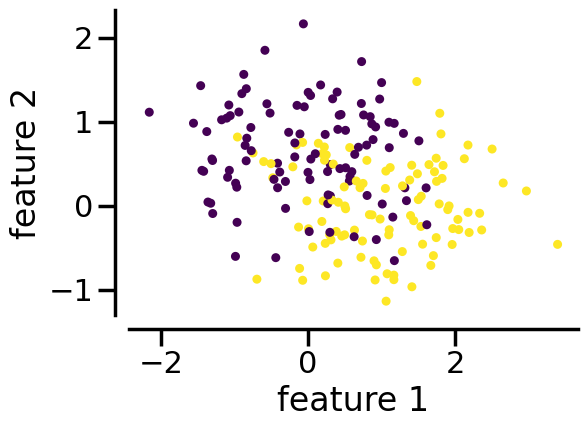

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, shuffle=True, noise=0.5, random_state=10)
X = pd.DataFrame(X, columns=["feature 1", "feature 2"])
ax = X.plot.scatter(
    x="feature 1",
    y="feature 2",
    c=y,
    colormap="viridis",
    colorbar=False,
)
sns.despine(ax=ax, offset=10)
plt.tight_layout()

## Make a dataset imbalanced

Now, we will show the helpers :func:`~imblearn.datasets.make_imbalance`
that is useful to random select a subset of samples. It will impact the
class distribution as specified by the parameters.



In [60]:
from collections import Counter


def ratio_func(y, multiplier, minority_class):
    target_stats = Counter(y)
    return {minority_class: int(multiplier * target_stats[minority_class])}

<Axes: xlabel='feature 1', ylabel='feature 2'>

Text(0.5, 1.0, 'Original set')

<Axes: xlabel='feature 1', ylabel='feature 2'>

Text(0.5, 1.0, 'Sampling ratio = 0.9')

<Axes: xlabel='feature 1', ylabel='feature 2'>

Text(0.5, 1.0, 'Sampling ratio = 0.75')

<Axes: xlabel='feature 1', ylabel='feature 2'>

Text(0.5, 1.0, 'Sampling ratio = 0.5')

<Axes: xlabel='feature 1', ylabel='feature 2'>

Text(0.5, 1.0, 'Sampling ratio = 0.25')

<Axes: xlabel='feature 1', ylabel='feature 2'>

Text(0.5, 1.0, 'Sampling ratio = 0.1')

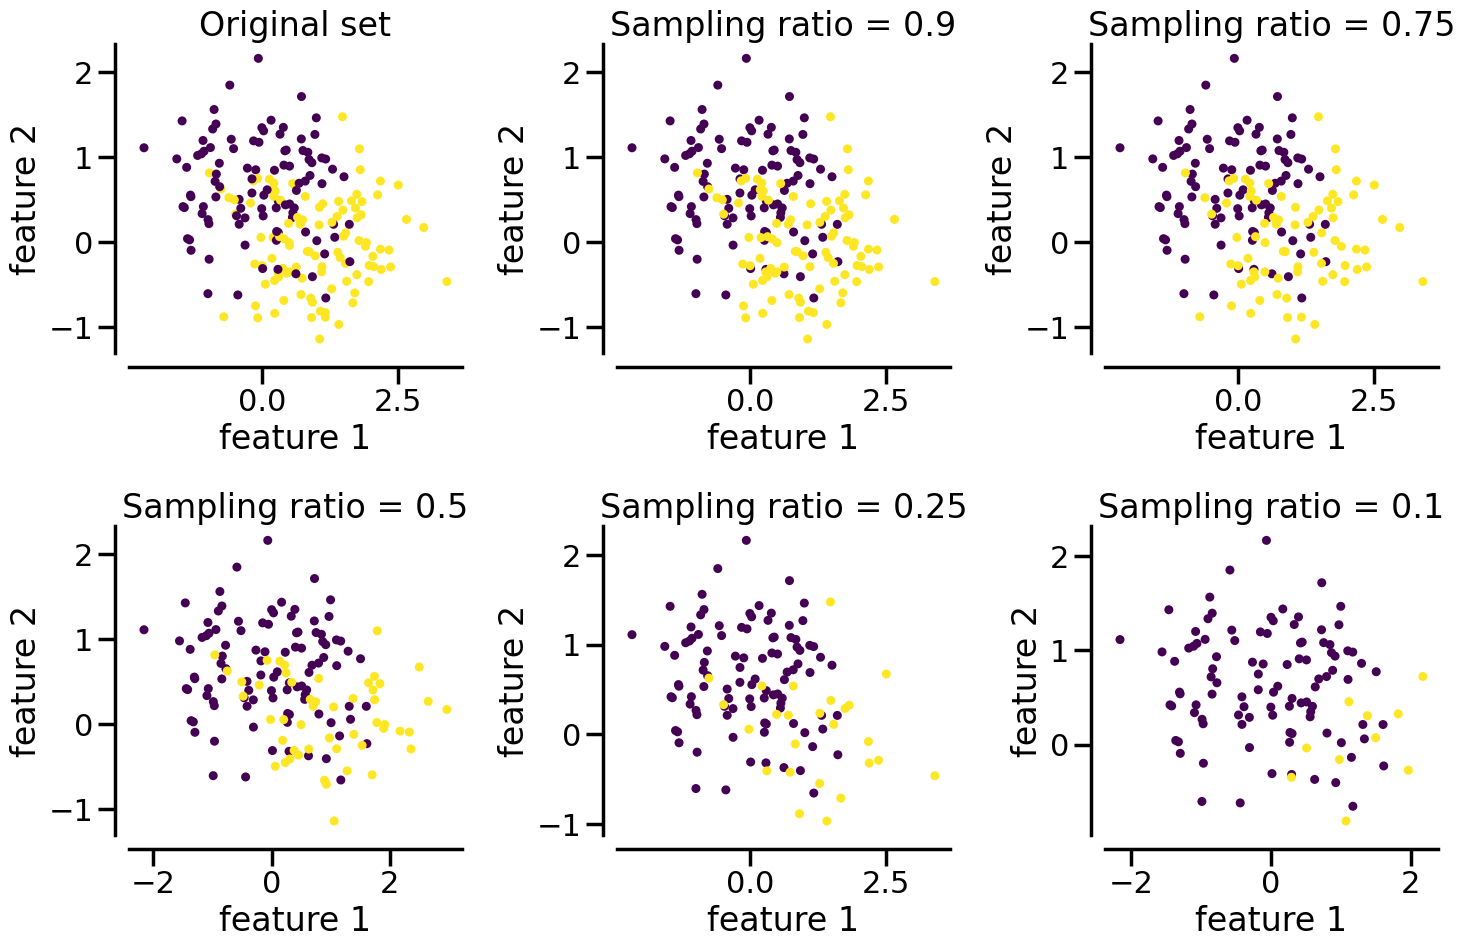

In [61]:
from imblearn.datasets import make_imbalance

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

X.plot.scatter(
    x="feature 1",
    y="feature 2",
    c=y,
    ax=axs[0, 0],
    colormap="viridis",
    colorbar=False,
)
axs[0, 0].set_title("Original set")
sns.despine(ax=axs[0, 0], offset=10)

multipliers = [0.9, 0.75, 0.5, 0.25, 0.1]
for ax, multiplier in zip(axs.ravel()[1:], multipliers):
    X_resampled, y_resampled = make_imbalance(
        X,
        y,
        sampling_strategy=ratio_func,
        **{"multiplier": multiplier, "minority_class": 1},
    )
    X_resampled.plot.scatter(
        x="feature 1",
        y="feature 2",
        c=y_resampled,
        ax=ax,
        colormap="viridis",
        colorbar=False,
    )
    ax.set_title(f"Sampling ratio = {multiplier}")
    sns.despine(ax=ax, offset=10)

plt.tight_layout()
plt.show()

Now, for ease of visualization, let's create a small unbalanced sample dataset using the <code>make_classification</code> method:

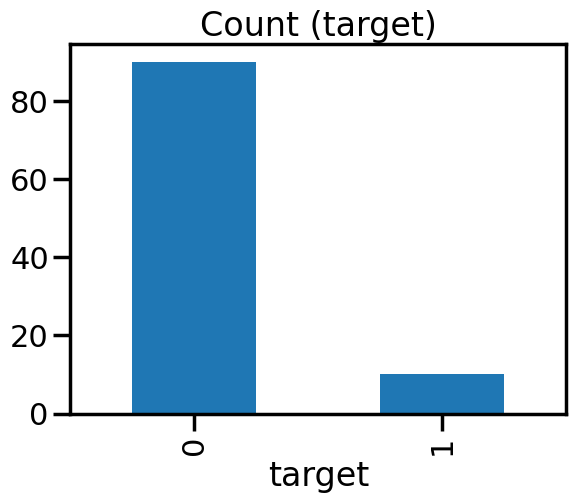

In [62]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

We will also create a 2-dimensional plot function, <code>plot_2d_space</code>, to see the data distribution:

In [63]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Because the dataset has many dimensions (features) and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):

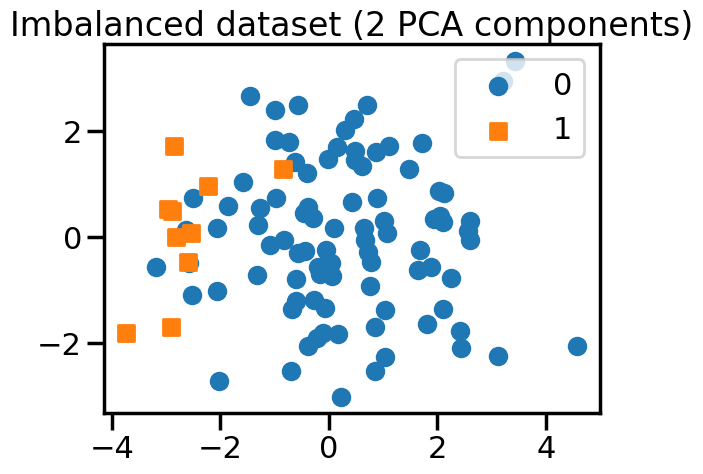

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

<h2 id="#t72">Random under-sampling and over-sampling with imbalanced-learn</h2>

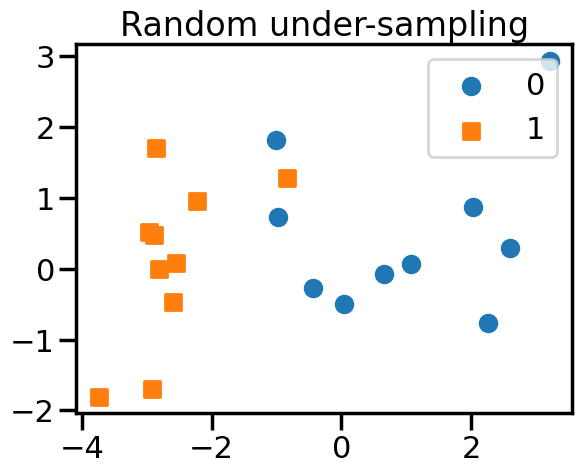

In [65]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

#print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new random picked points


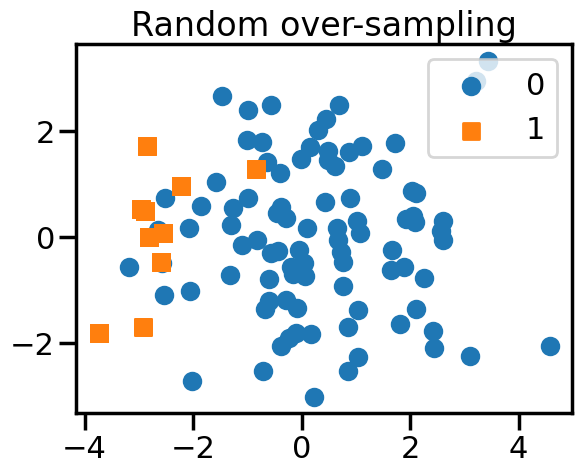

In [66]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

# Effect of the shrinkage factor in random over-sampling

This example shows the effect of the shrinkage factor used to generate the
smoothed bootstrap using the
:class:`~imblearn.over_sampling.RandomOverSampler`.


First, we will generate a toy classification dataset with only few samples.
The ratio between the classes will be imbalanced.



In [67]:
from collections import Counter

from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    weights=[0.1, 0.9],
    random_state=0,
)
Counter(y)

Counter({1: 90, 0: 10})

Text(0.5, 0, 'Feature #1')

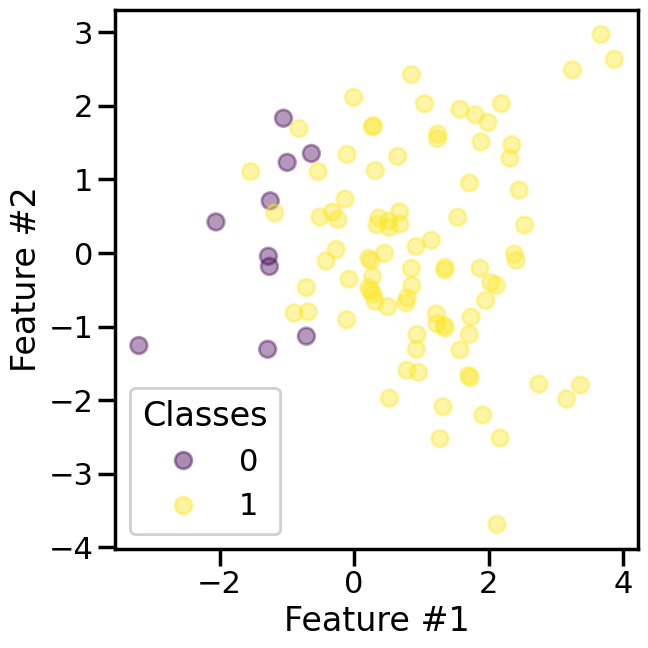

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.4)
class_legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(class_legend)
ax.set_xlabel("Feature #1")
_ = ax.set_ylabel("Feature #2")
plt.tight_layout()

Now, we will use a :class:`~imblearn.over_sampling.RandomOverSampler` to
generate a bootstrap for the minority class with as many samples as in the
majority class.



In [69]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=0)
X_res, y_res = sampler.fit_resample(X, y)
Counter(y_res)

Counter({1: 90, 0: 90})

Text(0.5, 0, 'Feature #1')

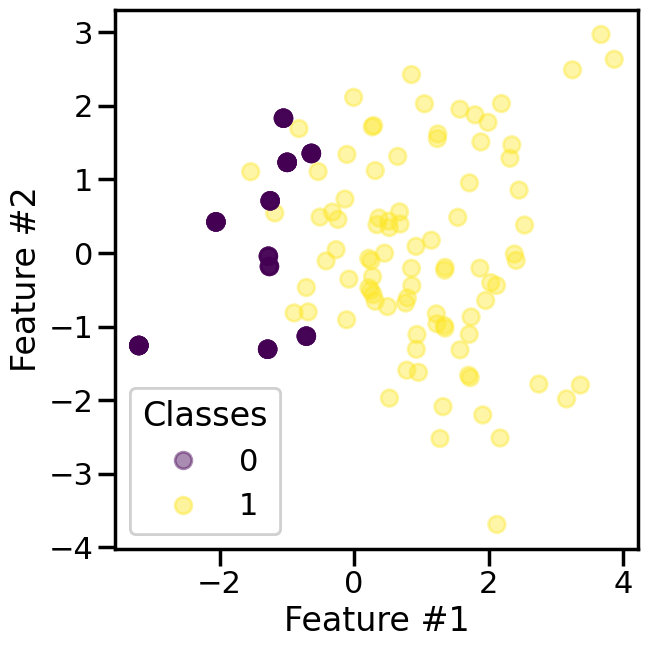

In [70]:
fig, ax = plt.subplots(figsize=(7, 7))
scatter = plt.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.4)
class_legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(class_legend)
ax.set_xlabel("Feature #1")
_ = ax.set_ylabel("Feature #2")
plt.tight_layout()

We observe that the minority samples are less transparent than the samples
from the majority class. Indeed, it is due to the fact that these samples
of the minority class are repeated during the bootstrap generation.

We can set `shrinkage` to a floating value to add a small perturbation to the
samples created and therefore create a smoothed bootstrap.



<div class="alert alert-success">
PLAYTIME: Study the effect of the shrinkage parameter. Why the samples in class 0 are darker when we use over-sampling? What happens for higher values of the shrinkage? Make similar plot varying the shrinkage parameter.
</div>

In [71]:
sampler = RandomOverSampler(## PUT YOUR CODE HERE ### , random_state=0)
## PUT YOUR CODE HERE ###
Counter(y_res)

Counter({1: 90, 0: 90})

Text(0.5, 0, 'Feature #1')

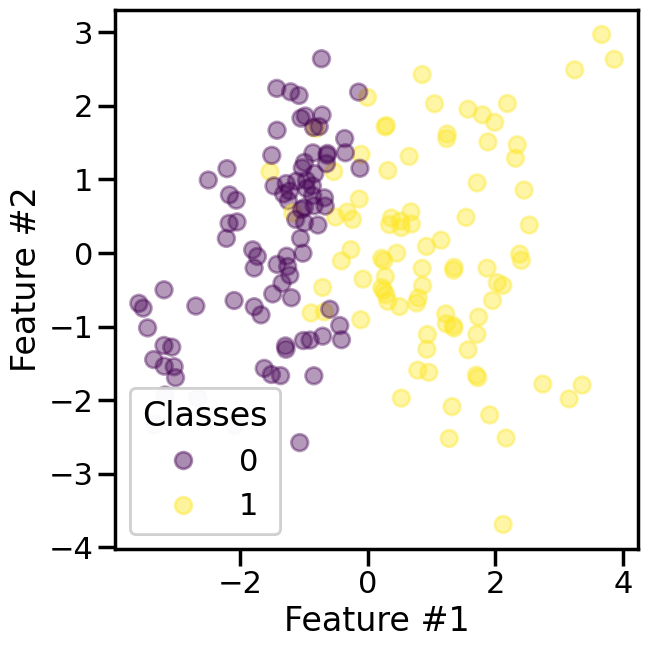

In [72]:
fig, ax = plt.subplots(figsize=(7, 7))
scatter = plt.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.4)
class_legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(class_legend)
ax.set_xlabel("Feature #1")
_ = ax.set_ylabel("Feature #2")
plt.tight_layout()

In this case, we see that the samples in the minority class are not
overlapping anymore due to the added noise.

The parameter `shrinkage` allows to add more or less perturbation. Let's
add more perturbation when generating the smoothed bootstrap.



In [73]:
sampler = RandomOverSampler(## PUT YOUR CODE HERE ###, random_state=0)
## PUT YOUR CODE HERE ###
Counter(y_res)

Counter({1: 90, 0: 90})

Text(0.5, 0, 'Feature #1')

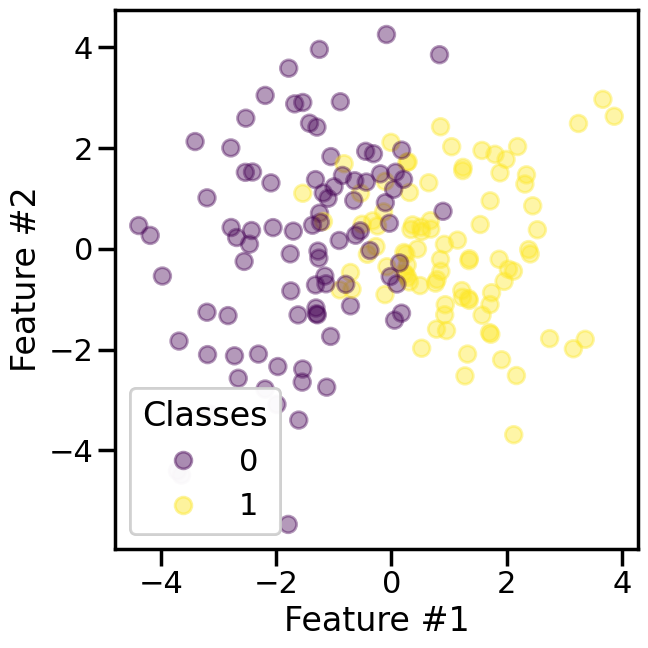

In [74]:
fig, ax = plt.subplots(figsize=(7, 7))
scatter = plt.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.4)
class_legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(class_legend)
ax.set_xlabel("Feature #1")
_ = ax.set_ylabel("Feature #2")
plt.tight_layout()

# Advanced sampling strategies

## Under-sampling: Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

In the code below, we'll use <code>ratio='majority'</code> to resample the majority class.

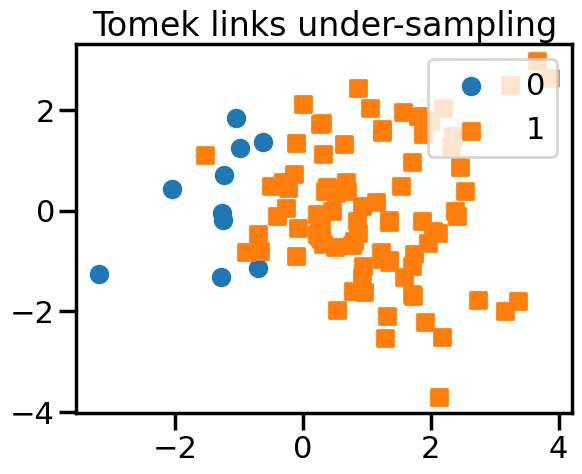

In [77]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

<h2 id="t9" style="margin-bottom: 18px">Under-sampling: Cluster Centroids</h2>

This technique performs under-sampling by generating centroids based on clustering methods. The data will be previously grouped by similarity, in order to preserve information.

In this example we will pass the <code>{0: 10}</code> dict for the parameter <code>ratio</code>, to preserve 10 elements from the majority class (0), and all minority class (1) .

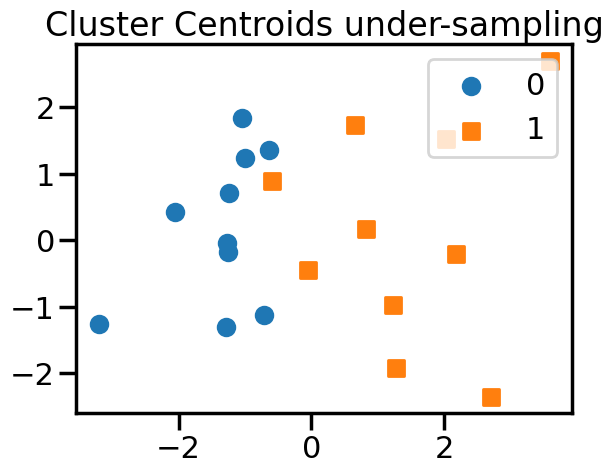

In [78]:
import imblearn
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

<h2 id="t10" style="margin-bottom: 18px">Over-sampling: SMOTE</h2>

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

We'll use <code>ratio='minority'</code> to resample the minority class.

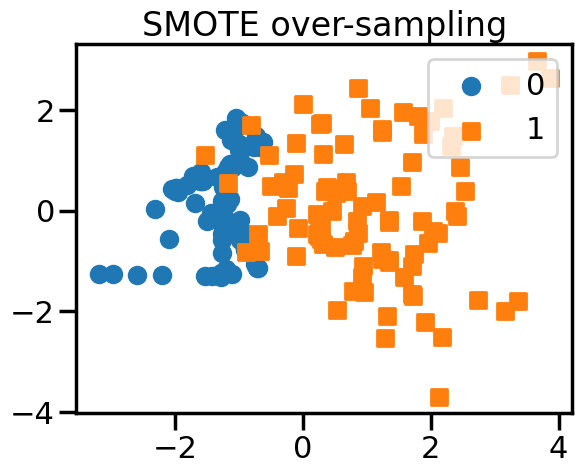

In [79]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

## Over-sampling followed by under-sampling

Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

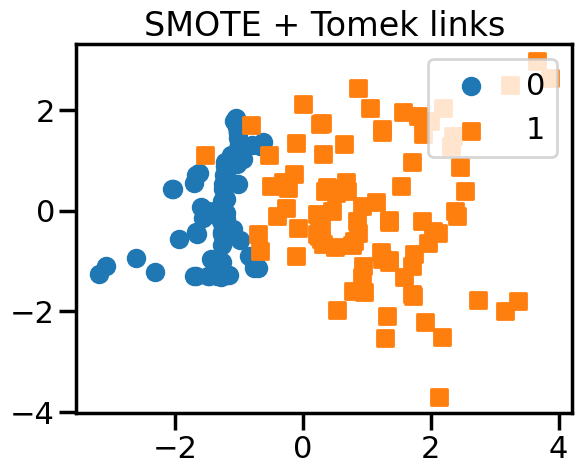

In [80]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

<div class="alert alert-success">
PLAYTIME: Study the different methods for under-sampling: random, tomek links and cluster centroids and for over-sampling ones: random and SMOTE for the dataset Porto Seguro. Plot the performance reports and a graph with a ROC curve for all the methods and using several classifiers: Logistic Regression, SVMs, Decision Trees and KNN classifiers. Use pipelines for standarizing and scaling the data. Which one is the best?
</div>

# BONUS TRACK: Sample generator used in SMOTE-like samplers

SMOTE the magic behind it...
This example illustrates how a new sample is generated taking into account the
neighbourhood of this sample. A new sample is generated by selecting the
randomly 2 samples of the same class and interpolating a point between these
samples.


Automatically created module for IPython interactive environment


Text(0.61, 3.5196799999999997, '$x_i$')

Text(0.41000000000000003, 3.22699, '$x_{zi}$')

Text(0.5089093252530315, 3.3717388520415486, '$x_{new}$')

(0.2, 0.7)

(3.2, 3.7)

Text(0.5, 0, '$X_1$')

Text(0, 0.5, '$X_2$')

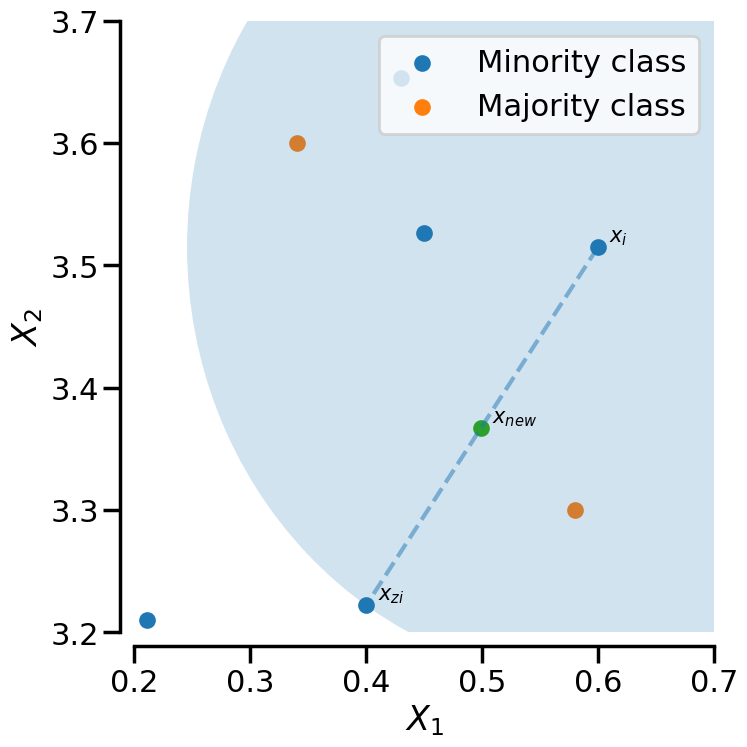

In [82]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("poster")

rng = np.random.RandomState(18)

f, ax = plt.subplots(figsize=(8, 8))

# generate some data points
y = np.array([3.65284, 3.52623, 3.51468, 3.22199, 3.21])
z = np.array([0.43, 0.45, 0.6, 0.4, 0.211])
y_2 = np.array([3.3, 3.6])
z_2 = np.array([0.58, 0.34])

# plot the majority and minority samples
ax.scatter(z, y, label="Minority class", s=100)
ax.scatter(z_2, y_2, label="Majority class", s=100)

idx = rng.randint(len(y), size=2)
annotation = [r"$x_i$", r"$x_{zi}$"]

for a, i in zip(annotation, idx):
    ax.annotate(a, (z[i], y[i]), xytext=tuple([z[i] + 0.01, y[i] + 0.005]), fontsize=15)

# draw the circle in which the new sample will generated
radius = np.sqrt((z[idx[0]] - z[idx[1]]) ** 2 + (y[idx[0]] - y[idx[1]]) ** 2)
circle = plt.Circle((z[idx[0]], y[idx[0]]), radius=radius, alpha=0.2)
ax.add_artist(circle)

# plot the line on which the sample will be generated
ax.plot(z[idx], y[idx], "--", alpha=0.5)

# create and plot the new sample
step = rng.uniform()
y_gen = y[idx[0]] + step * (y[idx[1]] - y[idx[0]])
z_gen = z[idx[0]] + step * (z[idx[1]] - z[idx[0]])

ax.scatter(z_gen, y_gen, s=100)
ax.annotate(
    r"$x_{new}$",
    (z_gen, y_gen),
    xytext=tuple([z_gen + 0.01, y_gen + 0.005]),
    fontsize=15,
)

# make the plot nicer with legend and label
sns.despine(ax=ax, offset=10)
ax.set_xlim([0.2, 0.7])
ax.set_ylim([3.2, 3.7])
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend()
plt.tight_layout()
plt.show()

# Recommended reading

The imbalanced-learn documentation:<br>
http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

The imbalanced-learn GitHub:<br>
https://github.com/scikit-learn-contrib/imbalanced-learn

Comparison of the combination of over- and under-sampling algorithms:<br>
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_comparison_combine.html

Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002):<br>
https://www.jair.org/media/953/live-953-2037-jair.pdf